# Plot a Spectral Signature

A spectral signature is a plot of the amount of light energy reflected by an object throughout the range of wavelengths in the electromagnetic spectrum. The spectral signature of an object conveys useful information about its structural and chemical composition. We can use these signatures to identify and classify different objects from a spectral image. 

For example, the atmosphere, soil, water, and vegetation have spectral signatures of distinctly different shapes, as illustrated in the following figure:
<p>
<center><strong>Example Spectral Signatures of Atmosphere, Soil, Water, and Vegetation</strong></center>
<img src="files/spectral_signatures.png" style="width: 400px;"/>
<center><font size="2">Figure: (Molero and Garzón, 2012)</font></center>
<center><font size="2">http://remotesensing.spiedigitallibrary.org/article.aspx?articleid=1352329</font></center>
</p>
Vegetation has a unique spectral signature characterized by high reflectance in the near infrared wavelengths, and much lower reflectance in the green portion of the visible spectrum. We can extract reflectance values in the NIR and visible spectrums from hyperspectral data in order to map vegetation on the earth's surface. We will explore this more in Lesson 4, where we will caluclate a Vegetation Index.  
<p><center><strong>Vegetation Spectrum<strong></center>
<img src="files/vegetation_spectrum.png" style="width: 600px;"/>
<center><font size="2">Figure: (Elowitz, retreived December 22, 2016) </font></center>
<center><font size="2">http://www.markelowitz.com/Hyperspectral.html</font></center>
<p>

## Objectives

In this exercise, we will learn how to extract and plot a spectral profile from a single pixel of a reflectance band in a NEON hyperspectral hdf5 file. To do this, we will use the **extract_band** function that we generated in Lesson 2, and the Python package **pandas** to create a dataframe for the reflectance and associated wavelength data. 

In [1]:
#Import required packages
import h5py
import numpy as np
import pandas as pd
import gdal
import matplotlib.pyplot as plt
import IPython.display 
from PIL import Image

#Set display Preferences
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore') #don't display warnings

In [2]:
# %load ./neon_aop.py
"""
Created on Wed Feb  8 10:06:25 2017

@author: bhass
"""

import numpy as np
import matplotlib.pyplot as plt
import h5py, gdal, osr, copy

#list_dataset lists the names of datasets in an hdf5 file
#call syntax: f.visititems(list_dataset)
def list_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(name)

#ls_dataset displays the name, shape, and type of datasets in hdf5 file
#call syntax: f.visititems(ls_dataset)
def ls_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(node)

def h5refl2array(refl_filename,sitename):

    hdf5_file = h5py.File(refl_filename,'r')
    refl = hdf5_file[sitename]['Reflectance']
    reflArray = refl['Reflectance_Data']
    refl_shape = reflArray.shape
    
    wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
    
    #Create metadata dictionary 
    metadata = {}
    metadata['shape'] = reflArray.shape
    metadata['mapInfo'] = refl['Metadata']['Coordinate_System']['Map_Info']
    #Extract no data value & set no data value to NaN
    metadata['noDataVal'] = float(reflArray.attrs['Data_Ignore_Value'])
    metadata['scaleFactor'] = float(reflArray.attrs['Scale_Factor'])
    
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['EPSG'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value 
    mapInfo_string = str(mapInfo); #print('Map Info:',mapInfo_string)
    mapInfo_split = mapInfo_string.split(",")
    
    #Extract the resolution & convert to floating decimal number
    metadata['res'] = {}
    metadata['res']['pixelWidth'] = mapInfo_split[5]
    metadata['res']['pixelHeight'] = mapInfo_split[6]

    #Extract the upper left-hand corner coordinates from mapInfo
    xMin = float(mapInfo_split[3]) 
    yMax = float(mapInfo_split[4])
    #Calculate the xMax and yMin values from the dimensions
    #xMax = left corner + (# of columns * resolution)
    xMax = xMin + (refl_shape[1]*float(metadata['res']['pixelWidth']))
    yMin = yMax - (refl_shape[0]*float(metadata['res']['pixelHeight'])) 
    metadata['extent'] = (xMin,xMax,yMin,yMax)
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = xMin
    metadata['ext_dict']['xMax'] = xMax
    metadata['ext_dict']['yMin'] = yMin
    metadata['ext_dict']['yMax'] = yMax

    return reflArray, metadata, wavelengths
    
def extract_raw_band(reflArray,reflArray_metadata,band_ind):
    bandArray = reflArray[:,:,band_ind-1].astype(np.float)
    return bandArray 

def extract_clean_band(reflArray,reflArray_metadata,band_ind):
    bandArray = reflArray[:,:,band_ind-1].astype(np.float)
    bandCleaned = copy.copy(bandArray)
    bandCleaned[bandCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    bandCleaned = bandCleaned/reflArray_metadata['scaleFactor']
    return bandCleaned   
    
def subset_clean_band(reflArray,reflArray_metadata,clipIndex,bandIndex):
    bandSubCleaned = reflArray[clipIndex['yMin']:clipIndex['yMax'],clipIndex['xMin']:clipIndex['xMax'],bandIndex-1].astype(np.float)
    bandSubCleaned[bandSubCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    bandSubCleaned = bandSubCleaned/reflArray_metadata['scaleFactor']
    return bandSubCleaned 

def subset_clean_refl(reflArray,reflArray_metadata,clipIndex):
    reflSubCleaned = reflArray[clipIndex['yMin']:clipIndex['yMax'],clipIndex['xMin']:clipIndex['xMax'],:].astype(np.float)
    reflSubCleaned[reflSubCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    reflSubCleaned = reflSubCleaned/reflArray_metadata['scaleFactor']
    return reflSubCleaned 

def plot_band_array(band_array,refl_extent,size=(6,6),title='',cmap_title='',colormap='spectral'):
    fig = plt.figure(figsize=size)
    plot = plt.imshow(band_array,extent=refl_extent); 
    cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

def array2raster(newRaster,reflBandArray,reflArray_metadata,epsg): 
    cols = reflBandArray.shape[1]
    rows = reflBandArray.shape[0]
    pixelWidth = float(reflArray_metadata['res']['pixelWidth'])
    pixelHeight = -float(reflArray_metadata['res']['pixelHeight'])
    originX = reflArray_metadata['ext_dict']['xMin']
    originY = reflArray_metadata['ext_dict']['yMax']
    
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create('hopb_b56.tif', cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(reflBandArray)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg) #4326 = WGS84
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def calc_clip_index(clipExtent, h5Extent, xscale=1, yscale=1):
    #Define a dictionary for the index extent (ind_ext):
    
    h5rows = h5Extent['yMax'] - h5Extent['yMin']
    h5cols = h5Extent['xMax'] - h5Extent['xMin']    
    
    ind_ext = {}
    ind_ext['xMin'] = round((clipExtent['xMin']-h5Extent['xMin'])/xscale)
    ind_ext['xMax'] = round((clipExtent['xMax']-h5Extent['xMin'])/xscale)
    ind_ext['yMax'] = round(h5rows - (clipExtent['yMin']-h5Extent['yMin'])/xscale)
    ind_ext['yMin'] = round(h5rows - (clipExtent['yMax']-h5Extent['yMin'])/yscale)

    return ind_ext
    
def stack_bands(reflArray,reflArray_metadata,bands):
    band_clean_dict = {}
    band_clean_names = []

    stackedArray = np.zeros((reflArray.shape[0],reflArray.shape[1],len(bands)),'uint8') #pre-allocate stackedArray matrix
    
    for i in range(len(bands)):
        band_clean_names.append("b"+str(bands[i])+"_refl_clean")
        band_clean_dict[band_clean_names[i]] = extract_clean_band(reflArray,reflArray_metadata,bands[i])
        stackedArray[...,i] = band_clean_dict[band_clean_names[i]]*256
                        
    return stackedArray
    
def stack_subset_bands(reflArray,reflArray_metadata,bands,clipIndex):
    band_clean_dict = {}
    band_clean_names = []

    subArray_rows = clipIndex['yMax'] - clipIndex['yMin']
    subArray_cols = clipIndex['xMax'] - clipIndex['xMin']
    
    stackedArray = np.zeros((subArray_rows,subArray_cols,len(bands)),'uint8') #pre-allocate stackedArray matrix
    
    for i in range(len(bands)):
        band_clean_names.append("b"+str(bands[i])+"_refl_clean")
        band_clean_dict[band_clean_names[i]] = subset_clean_band(reflArray,reflArray_metadata,clipIndex,bands[i])
        stackedArray[...,i] = band_clean_dict[band_clean_names[i]]*256
                        
    return stackedArray

In [3]:
sercRefl, sercRefl_md, wavelengths = h5refl2array('../data/SERC/hyperspectral/NEON_D02_SERC_DP1_20160807_160559_reflectance.h5','SERC')

for item in sorted(sercRefl_md):
    print(item + ':',sercRefl_md[item])

EPSG: 32618
ext_dict: {'yMax': 4310980.0, 'yMin': 4300128.0, 'xMin': 367167.0, 'xMax': 368273.0}
extent: (367167.0, 368273.0, 4300128.0, 4310980.0)
mapInfo: <HDF5 dataset "Map_Info": shape (), type "|O">
noDataVal: -9999.0
projection: b'+proj=UTM +zone= 18 +ellps= WGS-84 +datum= WGS-84 +units= units=Meters +no_defs'
res: {'pixelHeight': ' 1.0000000000e+000', 'pixelWidth': ' 1.0000000000e+000'}
scaleFactor: 10000.0
shape: (10852, 1106, 426)


In [4]:
# Extract subsetted band
clipExtDict = {}
clipExtDict['xMin'] = 367400.
clipExtDict['xMax'] = 368100.
clipExtDict['yMin'] = 4305750.
clipExtDict['yMax'] = 4306350.

clipExtent = (clipExtDict['xMin'],clipExtDict['xMax'],clipExtDict['yMin'],clipExtDict['yMax'])

clipIndex = calc_clip_index(clipExtDict,sercRefl_md['ext_dict'])

serc_b56_subset = subset_clean_band(sercRefl,sercRefl_md,clipIndex,55)
print('SERC Reflectance Subset Stats:')
print('min:',np.nanmin(serc_b56_subset))
print('max:',round(np.nanmax(serc_b56_subset),2))
print('mean:',round(np.nanmean(serc_b56_subset),2))

SERC Reflectance Subset Stats:
min: 0.0
max: 1.59
mean: 0.05


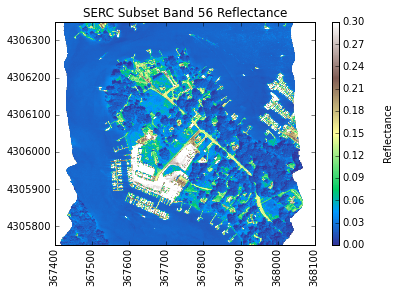

In [5]:
# plot_band_array(serc_b56_subset,clipExtent,size=(6,6),title='SERC Band 56 Subset',cmap_title='Reflectance',colormap='gist_earth')
plot = plt.imshow(serc_b56_subset,extent=clipExtent,clim=(0,0.3)); 
cbar = plt.colorbar(plot,aspect=30); plt.set_cmap('terrain'); 
cbar.set_label('Reflectance',rotation=90,labelpad=20)
plt.title('SERC Subset Band 56 Reflectance'); ax = plt.gca(); 
ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

In [6]:
print('SERC subset shape:',sercRefl.shape)
serc_pixel_df = pd.DataFrame()
serc_pixel_df['reflectance'] = sercRefl[5000,500,:]/sercRefl_md['scaleFactor']
serc_pixel_df['wavelengths'] = wavelengths
print(serc_pixel_df.head(5))
print(serc_pixel_df.tail(5))
# np.max(serc_pixel_df['reflectance'])

SERC subset shape: (10852, 1106, 426)
   reflectance  wavelengths
0       0.0341     383.6579
1       0.0388     388.6656
2       0.0420     393.6733
3       0.0376     398.6810
4       0.0359     403.6888
     reflectance  wavelengths
421       0.5144    2491.9070
422       0.3699    2496.9147
423       0.2988    2501.9224
424       0.6360    2506.9301
425       1.4882    2511.9379


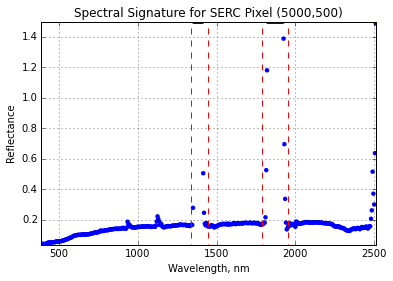

In [7]:
serc_pixel_df.plot(x='wavelengths',y='reflectance',kind='scatter',edgecolor='none');
plt.title('Spectral Signature for SERC Pixel (5000,500)')
ax = plt.gca() # ax = fig.add_subplot(1,2,1)
ax.set_xlim([np.min(wavelengths),np.max(wavelengths)]); 
ax.set_ylim([np.min(serc_pixel_df['reflectance']),np.max(serc_pixel_df['reflectance'])])
ax.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
ax.grid('on')

plt.plot((1340,1340),(0,1.5), 'r--')
plt.plot((1445,1445),(0,1.5), 'r--')

plt.plot((1790,1790),(0,1.5), 'r--')
plt.plot((1955,1955),(0,1.5), 'r--')

##  Water Vapor Band Windows 
We can see from the spectral profile above that there are spikes in reflectance around ~1400nm and ~1800nm. These result from water vapor which completely absorbs light between wavelengths 1340-1445 nm and 1790-1955 nm. The atmospheric correction that converts radiance to reflectance subsequently results in a spike at these two bands. This information is stored in the reflectance attributes: 

In [8]:
serc_refl = h5py.File('../data/SERC/hyperspectral/NEON_D02_SERC_DP1_20160807_160559_reflectance.h5','r')

## Apply Correction for Water Band
bw1 = serc_refl['SERC']['Reflectance'].attrs['Band_Window_1_Nanometers']; print('Band Window 1:',bw1)
bw2 = serc_refl['SERC']['Reflectance'].attrs['Band_Window_2_Nanometers']; print('Band Window 2:',bw2)

Band Window 1: [1340 1445]
Band Window 2: [1790 1955]


In [9]:
import copy
w = copy.copy(wavelengths.value)
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate
print(w)

[  383.6579   388.6656   393.6733   398.681    403.6888   408.6965
   413.7042   418.7119   423.7196   428.7274   433.7351   438.7428
   443.7505   448.7582   453.7659   458.7737   463.7814   468.7891
   473.7968   478.8045   483.8122   488.82     493.8277   498.8354
   503.8431   508.8508   513.8586   518.8663   523.874    528.8817
   533.8894   538.8971   543.9049   548.9126   553.9203   558.928
   563.9357   568.9434   573.9512   578.9589   583.9666   588.9743
   593.982    598.9898   603.9975   609.0052   614.0129   619.0206
   624.0283   629.0361   634.0438   639.0515   644.0592   649.0669
   654.0746   659.0824   664.0901   669.0978   674.1055   679.1132
   684.1209   689.1287   694.1364   699.1441   704.1518   709.1595
   714.1673   719.175    724.1827   729.1904   734.1981   739.2058
   744.2136   749.2213   754.229    759.2367   764.2444   769.2521
   774.2599   779.2676   784.2753   789.283    794.2907   799.2985
   804.3062   809.3139   814.3216   819.3293   824.337    829.3

(4300128.0, 4310980.0)

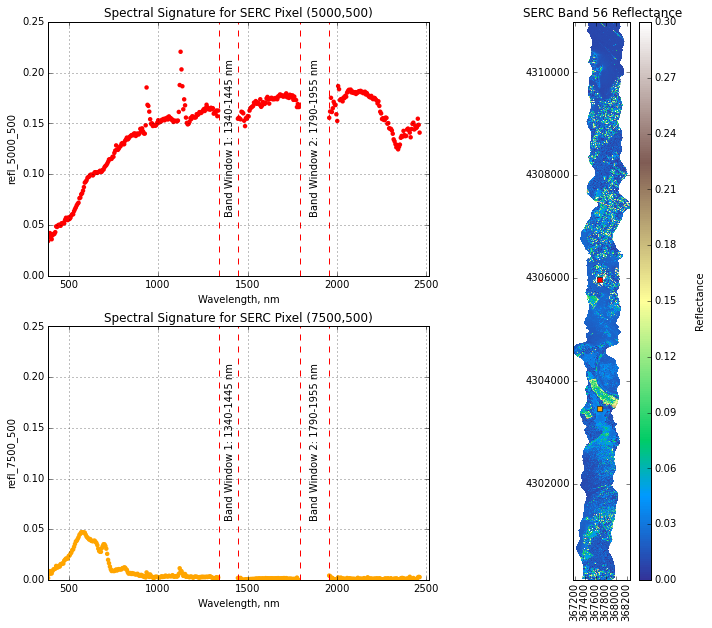

In [10]:
serc_pixel_df = pd.DataFrame()
serc_pixel_df['refl_5000_500'] = sercRefl[5000,500,:]/sercRefl_md['scaleFactor']
serc_pixel_df['refl_7500_500'] = sercRefl[7500,500,:]/sercRefl_md['scaleFactor']
serc_pixel_df['wavelengths'] = w

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,2,1)

serc_pixel_df.plot(ax=ax1,x='wavelengths',y='refl_5000_500',kind='scatter',color='red',edgecolor='none');
plt.title('Spectral Signature for SERC Pixel (5000,500)')
ax1.set_xlim([np.min(wavelengths),np.max(wavelengths)]); 
ax.set_ylim([np.min(serc_pixel_df['refl_5000_500']),np.max(serc_pixel_df['refl_5000_500'])*1.2])
ax1.set_ylim(0,0.25)
ax1.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
ax1.grid('on')

plt.plot((1340,1340),(0,1.5), 'r--')
plt.plot((1445,1445),(0,1.5), 'r--')

plt.plot((1790,1790),(0,1.5), 'r--')
plt.plot((1955,1955),(0,1.5), 'r--')

ax1.text(1375,0.205, 'Band Window 1: 1340-1445 nm', rotation='vertical')
ax1.text(1850,0.205, 'Band Window 2: 1790-1955 nm', rotation='vertical')

ax2 = fig.add_subplot(2,2,3)
serc_pixel_df.plot(ax=ax2,x='wavelengths',y='refl_7500_500',kind='scatter',color='orange',edgecolor='none');
plt.title('Spectral Signature for SERC Pixel (7500,500)')
ax2.set_xlim([np.min(wavelengths),np.max(wavelengths)]); 
ax.set_ylim([np.min(serc_pixel_df['refl_7500_500']),np.max(serc_pixel_df['refl_7500_500'])*1.2])
ax2.set_ylim(0,0.25)
ax2.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
ax2.grid('on')

plt.plot((1340,1340),(0,1.5), 'r--')
plt.plot((1445,1445),(0,1.5), 'r--')

plt.plot((1790,1790),(0,1.5), 'r--')
plt.plot((1955,1955),(0,1.5), 'r--')

ax2.text(1375,0.205, 'Band Window 1: 1340-1445 nm', rotation='vertical')
ax2.text(1850,0.205, 'Band Window 2: 1790-1955 nm', rotation='vertical')

#Plot RGB image of SERC flight line and location of pixel for reference:
# serc_rgbArray = stack_bands(sercRefl,sercRefl_md,(19,34,58))
ax3 = fig.add_subplot(1,4,3)
# plot band 56
serc_b56 = extract_clean_band(sercRefl,sercRefl_md,56)

plt.imshow(serc_b56,extent=sercRefl_md['extent'],clim=(0,0.3));  plt.hold('on')
cbar = plt.colorbar(plot,aspect=50); plt.set_cmap('terrain'); 
cbar.set_label('Reflectance',rotation=90,labelpad=20)
plt.title('SERC Band 56 Reflectance'); ax = plt.gca(); 
ax3.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

ax3.plot(sercRefl_md['ext_dict']['xMin']+500,sercRefl_md['ext_dict']['yMax']-5000,
        's',markersize=5,color='red')

ax3.plot(sercRefl_md['ext_dict']['xMin']+500,sercRefl_md['ext_dict']['yMax']-7500,
        's',markersize=5,color='orange')

ax3.set_xlim(sercRefl_md['extent'][0],sercRefl_md['extent'][1])
ax3.set_ylim(sercRefl_md['extent'][2],sercRefl_md['extent'][3])

## Spectra of Pixel from Subset of Flight Line Reflectance Band

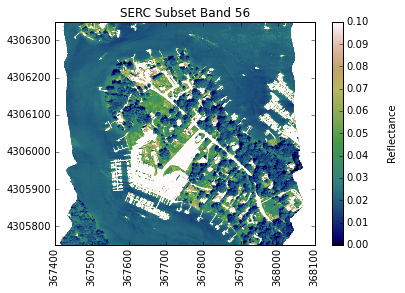

In [11]:
clipExtent = {}
clipExtent['xMin'] = 367400.
clipExtent['xMax'] = 368100.
clipExtent['yMin'] = 4305750.
clipExtent['yMax'] = 4306350.

clipExt = (clipExtent['xMin'],clipExtent['xMax'],clipExtent['yMin'],clipExtent['yMax'])

clipIndex = calc_clip_index(clipExtent,sercRefl_md['ext_dict'])

serc_b56_subset = subset_clean_band(sercRefl,sercRefl_md,clipIndex,56)
# sercRGBsubset = stack_subset_bands(sercRefl,sercRefl_md,(19,34,58),clipIndex)

plot = plt.imshow(serc_b56_subset,extent=clipExt,clim=(0,0.1)); 
plt.title('SERC Subset Band 56'); 
cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
cbar.set_label('Reflectance',rotation=90,labelpad=20); ax = plt.gca(); 
ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

In [12]:
sercRefl_subset = subset_clean_refl(sercRefl,sercRefl_md,clipIndex)

In [13]:
# Remove water vapor band windows and last 10 bands (containing noisy data)
w = copy.copy(wavelengths.value)
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate
nan_ind = np.argwhere(np.isnan(w))

serc_pixel_refl = sercRefl_subset[300,350,:]
serc_pixel_refl[nan_ind]=np.nan
# print(serc_pixel_refl)

(4305750.0, 4306350.0)

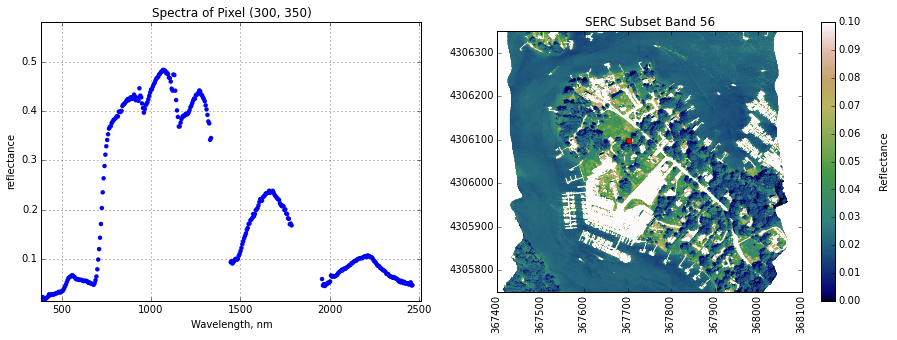

In [14]:
# Plot spectra and map with position of pixel:
pixel = (300,350)

w = copy.copy(wavelengths.value)
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate

serc_pixel_refl = sercRefl_subset[300,350,:]
serc_pixel_refl[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
serc_pixel_refl[-10:]=np.nan

serc_pixel_df = pd.DataFrame()
serc_pixel_df['reflectance'] = serc_pixel_refl
serc_pixel_df['wavelengths'] = w

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)

serc_pixel_df.plot(ax=ax1,x='wavelengths',y='reflectance',kind='scatter',edgecolor='none');
ax1.set_title('Spectra of Pixel ' + str(pixel))
ax1.set_xlim([np.min(wavelengths),np.max(wavelengths)]); # ax2.set_ylim(0,0.25)
ax1.set_ylim([np.min(serc_pixel_df['reflectance']),np.max(serc_pixel_df['reflectance'])*1.2])
ax1.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
ax1.grid('on'); 

ax2 = fig.add_subplot(1,2,2)
plot = plt.imshow(serc_b56_subset,extent=clipExt,clim=(0,0.1)); 
plt.title('SERC Subset Band 56'); 
cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
cbar.set_label('Reflectance',rotation=90,labelpad=20); 
ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

ax2.plot(clipExtent['xMin']+300,clipExtent['yMin']+350,'s',markersize=5,color='red')
ax2.set_xlim(clipExt[0],clipExt[1])
ax2.set_ylim(clipExt[2],clipExt[3])

## Interactive Spectra Visualization

In [15]:
refl_band = serc_b56_subset

w = copy.copy(wavelengths.value)
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
#use band window values from reflectance attributes 
# w[((w >= bw1[0]) & (w <= bw1[1])) | ((w >= bw2[0]) & (w <= bw2[1]))]=np.nan 
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate
nan_ind = np.argwhere(np.isnan(w))
# print(nan_ind.shape)

serc_pixel_refl = sercRefl_subset[300,350,:]
serc_pixel_refl[nan_ind]=np.nan

refl = copy.copy(sercRefl_subset)
print(refl.shape)

(600, 700, 426)


<function __main__.spectraPlot>

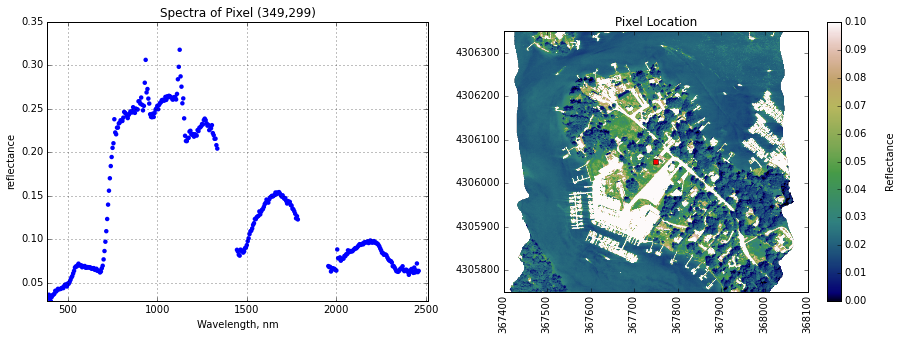

In [16]:
from IPython.html.widgets import *

def spectraPlot(pixel_x,pixel_y):

    reflectance = refl[pixel_y,pixel_x,:]
    reflectance[nan_ind]=np.nan
    
    pixel_df = pd.DataFrame()
    pixel_df['reflectance'] = reflectance
    pixel_df['wavelengths'] = w

    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(1,2,1)

    # fig, axes = plt.subplots(nrows=1, ncols=2)
    pixel_df.plot(ax=ax1,x='wavelengths',y='reflectance',kind='scatter',edgecolor='none');
    ax1.set_title('Spectra of Pixel (' + str(pixel_x) + ',' + str(pixel_y) + ')')
    ax1.set_xlim([np.min(wavelengths),np.max(wavelengths)]); 
    ax1.set_ylim([np.min(pixel_df['reflectance']),np.max(pixel_df['reflectance']*1.1)])
    ax1.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
    ax1.grid('on')

    ax2 = fig.add_subplot(1,2,2)
    plot = plt.imshow(refl_band,extent=clipExt,clim=(0,0.1)); 
    plt.title('Pixel Location'); 
    cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
    cbar.set_label('Reflectance',rotation=90,labelpad=20); 
    ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
    rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
    
    ax2.plot(clipExtent['xMin']+pixel_x,clipExtent['yMax']-pixel_y,'s',markersize=5,color='red')
    ax2.set_xlim(clipExt[0],clipExt[1])
    ax2.set_ylim(clipExt[2],clipExt[3])
    
interact(spectraPlot, pixel_x = (0,refl.shape[1]-1,1),pixel_y=(0,refl.shape[0]-1,1))

## Explore the Data

Move around the pixel to different parts of the reflectance image. Look at the spectra of water, trees, grass, and concrete. What general patterns can you see?

(4305750.0, 4306350.0)

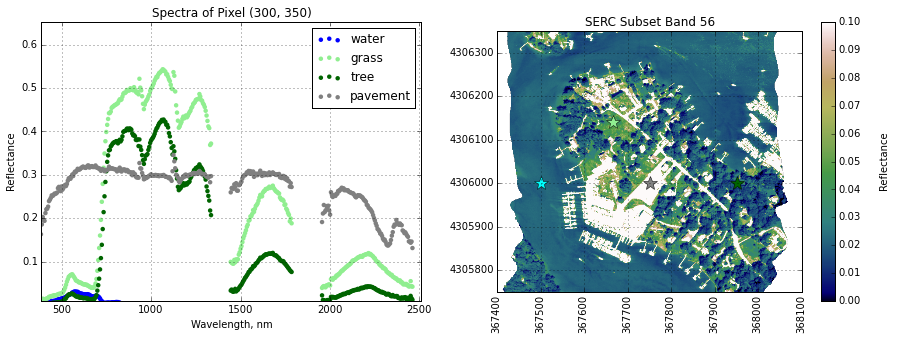

In [17]:
refl = copy.copy(sercRefl_subset)

w = copy.copy(wavelengths.value)
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate

nan_ind = np.argwhere(np.isnan(w))

refl_water = refl[350,100,:]; refl_water[nan_ind]=np.nan
refl_grass = refl[210,265,:]; refl_grass[nan_ind]=np.nan
refl_tree = refl[350,550,:]; refl_tree[nan_ind]=np.nan
refl_pavement = refl[350,350,:]; refl_pavement[nan_ind]=np.nan

serc_pixel_df = pd.DataFrame()
serc_pixel_df['refl_water'] = refl_water
serc_pixel_df['refl_grass'] = refl_grass
serc_pixel_df['refl_tree'] = refl_tree
serc_pixel_df['refl_pavement'] = refl_pavement
serc_pixel_df['wavelengths'] = w

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); plt.hold(True)

serc_pixel_df.plot(ax=ax1,x='wavelengths',y='refl_water',label='water',legend=True,color='blue',edgecolor='none',kind='scatter');
serc_pixel_df.plot(ax=ax1,x='wavelengths',y='refl_grass',color='lightgreen',edgecolor='none',kind='scatter',label='grass',legend=True);
serc_pixel_df.plot(ax=ax1,x='wavelengths',y='refl_tree',color='darkgreen',edgecolor='none',kind='scatter',label='tree',legend=True);
serc_pixel_df.plot(ax=ax1,x='wavelengths',y='refl_pavement',color='gray',edgecolor='none',kind='scatter',label='pavement',legend=True);

ax1.set_title('Spectra of Pixel ' + str(pixel))
ax1.set_xlim([np.min(wavelengths),np.max(wavelengths)]); 
ax1.set_ylim([np.min(serc_pixel_df['refl_grass']),np.max(serc_pixel_df['refl_grass'])*1.2])
ax1.set_xlabel("Wavelength, nm"); ax1.set_ylabel("Reflectance")
ax1.grid('on'); 

ax2 = fig.add_subplot(1,2,2)
plot = plt.imshow(serc_b56_subset,extent=clipExt,clim=(0,0.1)); 
plt.title('SERC Subset Band 56'); plt.grid('on')
cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
cbar.set_label('Reflectance',rotation=90,labelpad=20); 
ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

ax2.plot(clipExtent['xMin']+100,clipExtent['yMax']-350,'*',markersize=15,color='cyan') #water
ax2.plot(clipExtent['xMin']+265,clipExtent['yMax']-210,'*',markersize=15,color='lightgreen') #grass
ax2.plot(clipExtent['xMin']+550,clipExtent['yMax']-350,'*',markersize=15,color='darkgreen') #tree
ax2.plot(clipExtent['xMin']+350,clipExtent['yMax']-350,'*',markersize=15,color='gray') #pavement

ax2.set_xlim(clipExt[0],clipExt[1])
ax2.set_ylim(clipExt[2],clipExt[3])

## View Mean Spectra of Subset

In [18]:
#Water
clipWaterExtDict = {}
clipWaterExtDict['xMin'] = 367900
clipWaterExtDict['xMax'] = 368000
clipWaterExtDict['yMin'] = 4306200
clipWaterExtDict['yMax'] = 4306300

clipWaterExtent = (clipWaterExtDict['xMin'],clipWaterExtDict['xMax'],clipWaterExtDict['yMin'],clipWaterExtDict['yMax'])
clipWaterIndex = calc_clip_index(clipWaterExtDict,sercRefl_md['ext_dict']); # print(clipWaterIndex)

reflWaterClip = subset_clean_refl(sercRefl,sercRefl_md,clipWaterIndex)

#Pavement
clipPavementExtDict = {}
clipPavementExtDict['xMin'] = 367610
clipPavementExtDict['xMax'] = 367660
clipPavementExtDict['yMin'] = 4305910
clipPavementExtDict['yMax'] = 4305960

clipPavementExtent = (clipPavementExtDict['xMin'],clipPavementExtDict['xMax'],clipPavementExtDict['yMin'],clipPavementExtDict['yMax'])
clipPavementIndex = calc_clip_index(clipPavementExtDict,sercRefl_md['ext_dict'])
# print(clipWaterIndex)

reflPavementClip = subset_clean_refl(sercRefl,sercRefl_md,clipPavementIndex)

#Grass
clipGrassExtDict = {}
clipGrassExtDict['xMin'] = 367630
clipGrassExtDict['xMax'] = 367680
clipGrassExtDict['yMin'] = 4306110
clipGrassExtDict['yMax'] = 4306160

clipGrassExtent = (clipGrassExtDict['xMin'],clipGrassExtDict['xMax'],clipGrassExtDict['yMin'],clipGrassExtDict['yMax'])
clipGrassIndex = calc_clip_index(clipGrassExtDict,sercRefl_md['ext_dict'])
# print(clipWaterIndex)

reflGrassClip = subset_clean_refl(sercRefl,sercRefl_md,clipGrassIndex)

In [19]:
def plot_polygon(clipExtDict,ax=ax,color='white',annotation='off'):
    from matplotlib.path import Path
    import matplotlib.patches as patches
    
    verts = [
        (clipExtDict['xMin'],clipExtDict['yMin']), #lower left
        (clipExtDict['xMin'],clipExtDict['yMax']), #upper left
        (clipExtDict['xMax'],clipExtDict['yMax']), #upper right
        (clipExtDict['xMax'],clipExtDict['yMin']), #lower right
        (clipExtDict['xMin'],clipExtDict['yMin'])] #lower left - close polygon
    
    codes = [Path.MOVETO,
            Path.LINETO,
            Path.LINETO,
            Path.LINETO,
            Path.CLOSEPOLY]
    
    path = Path(verts,codes)
    patch = patches.PathPatch(path,edgecolor=color,facecolor='none',lw=2)
    ax.add_patch(patch)
    plt.grid(True); plt.rc('grid',color=color)
    if annotation == 'on':
        ax.annotate('Clipped Region', xy=(clipExtDict['xMax'],clipExtDict['yMax']),
                   xytext=(clipExtDict['xMax']+50,clipExtDict['yMax']+50),color=color,
                   arrowprops=dict(facecolor=color,frac=0.25,shrink=0.05))

(4305750.0, 4306350.0)

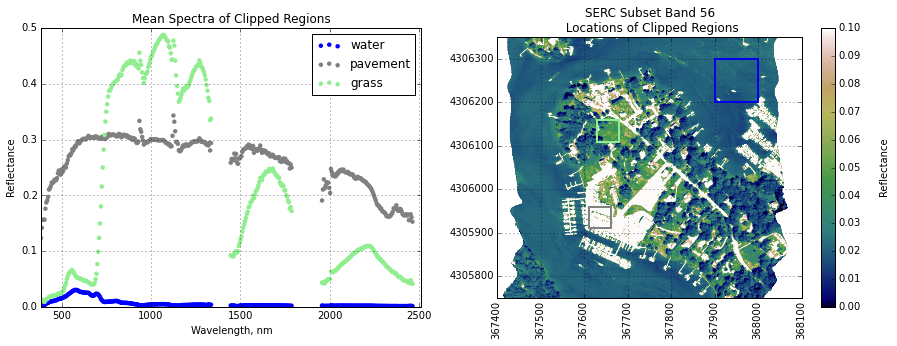

In [20]:
#Plot Mean Spectra
# print(reflWaterClip.shape)

w = copy.copy(wavelengths.value)
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
w[-10:]=np.nan; # print(w)

nan_ind = np.argwhere(np.isnan(w))

waterClipMeanRefl = reflWaterClip.mean(axis=(0,1))
waterClipMeanRefl[nan_ind]=np.nan

clipSpectra_df = pd.DataFrame()
clipSpectra_df['refl_water'] = waterClipMeanRefl
clipSpectra_df['refl_pavement'] = reflPavementClip.mean(axis=(0,1))
clipSpectra_df['refl_grass'] = reflGrassClip.mean(axis=(0,1))
clipSpectra_df['wavelengths'] = w

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); plt.hold(True)

clipSpectra_df.plot(ax=ax1,x='wavelengths',y='refl_water',label='water',legend=True,color='blue',edgecolor='none',kind='scatter')
clipSpectra_df.plot(ax=ax1,x='wavelengths',y='refl_pavement',label='pavement',legend=True,color='gray',edgecolor='none',kind='scatter')
clipSpectra_df.plot(ax=ax1,x='wavelengths',y='refl_grass',label='grass',legend=True,color='lightgreen',edgecolor='none',kind='scatter')

ax1.set_xlim([np.min(wavelengths),np.max(wavelengths)]); # ax2.set_ylim(0,0.25)
ax1.set_ylim([0,0.5]); plt.grid('on')
ax1.set_xlabel("Wavelength, nm"); ax1.set_ylabel("Reflectance")
ax1.set_title('Mean Spectra of Clipped Regions')

#Plot Polygons of Clipped Regions on Map
ax2 = fig.add_subplot(1,2,2); plt.hold(True)
plot = plt.imshow(serc_b56_subset,extent=clipExt,clim=(0,0.1)); 
plt.title('SERC Subset Band 56 \n Locations of Clipped Regions'); plt.grid('on')
cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
cbar.set_label('Reflectance',rotation=90,labelpad=20); 
ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
plt.hold('on'); plt.grid('on')

plot_polygon(clipWaterExtDict,ax=ax2,color='blue')
plot_polygon(clipPavementExtDict,ax=ax2,color='gray')
plot_polygon(clipGrassExtDict,ax=ax2,color='lightgreen')

ax2.set_xlim(clipExt[0],clipExt[1])
ax2.set_ylim(clipExt[2],clipExt[3])

# THE PART BELOW HERE NEEDS WORK

## Function to Extract Spectra of a Single Pixel
Now that we see how to plot a spectra, let's make a function to automate this process: 

In [ ]:
def extract_pixel_spectra(refl_hdf5,site,pixel):
    reflArray, reflArray_md, wavelengths = h5refl2array(refl_hdf5,site)
    reflArray[reflArray=reflArray_md['noDataVal']]=np.nan
    
    #remove data from water vapor band windows
    w = copy.copy(wavelengths.value)
    w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
    w[-10:]=np.nan
    
    nan_ind = np.argwhere(np.isnan(w))
    
    pixel_spectra = pd.DataFrame()
    pixel_spectra['reflectance'] = reflArray[pixel[1],pixel[0],:]/reflArray_md['scaleFactor']
    pixel_spectra['wavelengths'] = w
    
    return spectra_df

# def plot_spectra_map(pixel_spectra)

### Create a function to make a dataframe containing wavelength and reflectance for a single pixel.

Note that to plot multiple pixels, we had to repeat the same lines of code multiple times. We can make this process more efficient by creating a function that makes a dataframe given the pixel index.

### References

Elowitz, Mark R. "What is Imaging Spectroscopy (Hyperspectral Imaging)?" http://www.markelowitz.com/Hyperspectral.html

Molero, José M. and Garzón, Ester M. Inmaculada García and Antonio Plaza "Anomaly detection based on a parallel kernel RX algorithm for multicore platforms", J. Appl. Remote Sens. 6(1), 061503 (May 10, 2012). ; http://dx.doi.org/10.1117/1.JRS.6.061503. 